# Avancement projet Anomalies, 2 avril

## Téléchargement des librairies

In [1]:
import pandas as pd
import numpy as np
import os
import pickle

#Fonctions statistiques 
import scipy.stats

# ACP
import sklearn.decomposition as sd
import sklearn.preprocessing as sp
# FFT
from scipy.fftpack import fft
# Hierarchical clustering
import scipy.cluster.hierarchy as sch
#Wavelet
import pywt
from pywt import wavedec
from statsmodels.robust import mad
# LOF
import sklearn.neighbors as sn
# Isolation Forest
import sklearn.ensemble as se
#One Class SVM
import sklearn.svm as ssvm

# Plot et Display
from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sb
sb.set()
sb.set_style("darkgrid", {"axes.facecolor": ".9"})

# Interactive display
from ipywidgets import interact, widgets, interactive, fixed, interact_manual
from IPython.display import display

## Lecture des données

On lit directement les données nettoyées et dont la longueur a été modifiée à 1024.

In [2]:
import pickle
with open('X_1024', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    X_1024, ind = mon_depickler.load() #X_1024 : données  #ind : liste des indices des signaux
n = len(X_1024) #nb de signaux
liste_appr = list(np.asarray(X_1024)[np.asarray(ind) <= 299])
liste_test = list(np.asarray(X_1024)[np.asarray(ind) > 299])
n_appr = len(liste_appr)

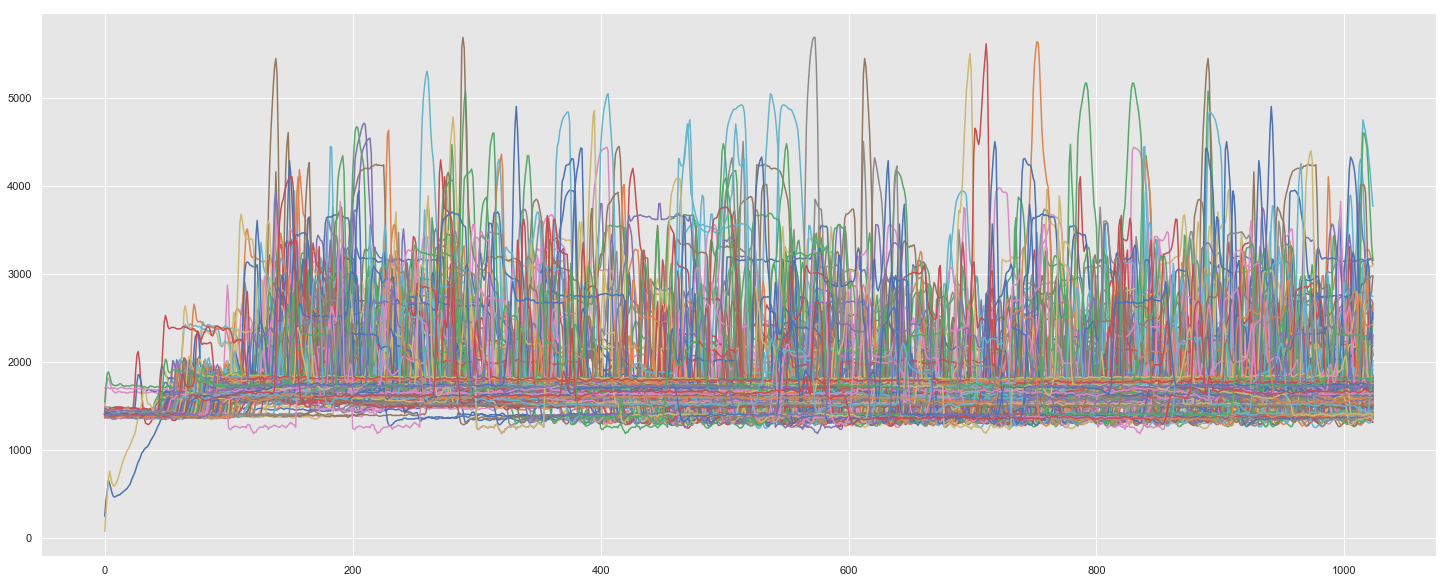

In [3]:
fig = plt.figure(figsize=(25, 10))
for x in X_1024:
    plt.plot(x)

# Coefficients de Fourier

In [4]:
fftCoeff = []

for x in X_1024 :
    mx = np.mean(x)
    x_centre = x - mx
    #Apply fast Fourier transform
    coeffsfft = np.abs(fft(x_centre))
    coeffsfft_flatten = np.hstack(coeffsfft)
    fftCoeff.append(coeffsfft_flatten)

fftCoeff = np.array(fftCoeff)
print(fftCoeff.shape)

#Coefficients seuillés
prop_a_garder = 0.1
nb_coeffs = int(fftCoeff.shape[1] * prop_a_garder)
somme = np.sum(fftCoeff**2, axis=0)
fftCoeff_seuil = np.zeros((0, nb_coeffs))
ind_grands = np.argsort(somme)[-nb_coeffs :]
fftCoeff_seuil = fftCoeff[:, ind_grands]

print(fftCoeff_seuil.shape)

(425, 1024)
(425, 102)


# Décomposition en ondelettes

On effectue la décomposition en ondelettes pour chaque signal et on récupère 2 tableaux de coefficients, l'un avec tous les coefficients de chaque signal, l'autre avec les coefficients seuillés. On pourra réaliser la décomposition en ondelettes seuillés avec les modes `hard`, `soft`, `greater` ou `less`.

In [5]:
wavelist=['haar','db2'] 
wf = 'haar' #Choix de l'ondelette

Coeff_ond = []
Coeff_ondT = []
for x in X_1024:
    #Apply wavelet decomposition
    coeffs = pywt.wavedec(x,wf,level=8) 
    coeffs_flatten = np.hstack(coeffs)
    Coeff_ond.append(coeffs_flatten)
    # Compute universal Threshold http://jseabold.net/blog/2012/02/23/wavelet-regression-in-python/
    sigma = mad(coeffs[-1])
    uthresh = sigma*np.sqrt(2*np.log(1024))
    # Apply Threshold on 4 first levels
    coeffs_thresh = [pywt.threshold(c, uthresh, mode="hard") if j<=3 else c for j,c in enumerate(coeffs[::-1])]
    coeffs_thresh_flatten = np.hstack(coeffs_thresh[::-1])
    Coeff_ondT.append(coeffs_thresh_flatten)
    
Coeff_ond = np.array(Coeff_ond)
Coeff_ondT = np.array(Coeff_ondT)
print(Coeff_ond.shape, Coeff_ondT.shape)
print(np.sum(Coeff_ond!=0), np.sum(Coeff_ondT!=0))

(425, 1024) (425, 1024)
304114 137127


#### Choix des coefficients d'ondelettes

In [6]:
#Coefficient de niveau 7 à 10:
Coeff_ond7=Coeff_ond[:,128:]
#Coefficient de niveau 1 à 6 : 
Coeff_ondA6=Coeff_ond[:,:128]
#Coefficient de niveau 1 à 4 : 
Coeff_ondA4=Coeff_ond[:,:16]

## Features

In [7]:
with open('liste_propre', 'rb') as fichier:
    mon_depickler = pickle.Unpickler(fichier)
    liste_comp, ind = mon_depickler.load() #liste_comp : données  #ind : liste des indices des signaux
n = len(liste_comp) #nb de signaux
liste_appr = list(np.asarray(liste_comp)[np.asarray(ind) <= 299])
liste_test = list(np.asarray(liste_comp)[np.asarray(ind) > 299])

## Liste des features  

- min, max
- mean 
- écart type 
- Skewness 
- Kurtosis 
- Energy 
- Average Crossing 

A ajouter ?

- Distribution spectrale d'énergie 
- Pourcentage d'extrema locaux 

https://arc.aiaa.org/doi/pdf/10.2514/6.2016-2430

In [8]:
listeMin = [min(liste) for liste in liste_comp]
listeMax = [max(liste) for liste in liste_comp]
listeMean = [np.mean(liste) for liste in liste_comp]
listeStd = [np.std(liste) for liste in liste_comp]
listeSkewness = [scipy.stats.skew(liste) for liste in liste_comp]
listeKurtosis = [scipy.stats.kurtosis(liste) for liste in liste_comp]
listeEnergy = [sum(np.asarray(liste)**2)/len(liste) for liste in liste_comp]
listeAverageCross = [sum(1*(liste > np.mean(liste)))/len(liste) for liste in liste_comp]

### Construction du DataFrame

In [9]:
dico = {"Min": listeMin, "Max": listeMax, "Moyenne": listeMean, "Ecart-type": listeStd, "Skewness" : listeSkewness, "Kurtosis": listeKurtosis, "Energie": listeEnergy, "Average_Crossing": listeAverageCross}
DataFeatures = pd.DataFrame(dico)

In [10]:
data_train = DataFeatures.iloc[: len(liste_appr), :]
data_test = DataFeatures.iloc[len(liste_appr) :, :]
data_test.describe()

,Min,Max,Moyenne,Ecart-type,Skewness,Kurtosis,Energie,Average_Crossing
count,128.000000,128.000000,128.000000,128.000000,128.000000,128.000000,1.280000e+02,128.000000
mean,1312.140625,3041.000000,1681.131871,256.957453,1.832478,10.296867,2.916155e+06,0.501287
std,119.882931,836.939306,87.738878,128.116474,2.059130,12.165659,3.564267e+05,0.235063
min,72.000000,1624.000000,1524.917609,57.801247,-2.870609,-1.763901,2.362471e+06,0.070284
25%,1302.000000,2458.000000,1613.451399,159.614775,0.145547,2.287839,2.650776e+06,0.235914
50%,1320.000000,2940.000000,1658.573002,216.153077,1.883105,6.979544,2.811549e+06,0.600456
75%,1354.000000,3570.000000,1752.847804,303.359617,3.154531,13.219379,3.138162e+06,0.699531
max,1432.000000,5616.000000,1894.520301,703.874510,6.964047,58.596857,4.084646e+06,0.861538


## ACP 

In [11]:
pca = sd.PCA()
data = DataFeatures[["Min","Max","Moyenne","Ecart-type","Skewness","Kurtosis","Energie", "Average_Crossing"]]
C = pca.fit_transform(sp.scale(data))

In [12]:
def plot_var_ACP(X_acp,acp) :
    fig = plt.figure(figsize=(15,7))
    ax = fig.add_subplot(1,2,1)
    ax.bar(range(5), acp.explained_variance_ratio_[:5]*100, align='center', color='grey', ecolor='black')
    ax.set_xticks(range(10))
    ax.set_ylabel("Variance")
    ax.set_title("Pourcentage de variance expliquée \n des premières composantes", fontsize=20)

    ax = fig.add_subplot(1,2,2)
    box = ax.boxplot(X_acp[:, 0:10])
    ax.set_title("Distribution des premières composantes", fontsize=20)
    plt.show()
    
def plot_proj_ACP(X_acp, axe_1=0, axe_2=1, etiq=True) :
    fig = plt.figure(figsize=(13,8))
    ax = fig.add_subplot(1,1,1)
    dict_color = {True : "blue", False : "red"}

    for x, y, s in zip(X_acp[:,axe_1], X_acp[:,axe_2], range(n)) :
        ax.plot(x,y,marker=".", color=dict_color[s < len(liste_appr)])
        if etiq :
            ax.text(x, y, str(s))
       
    ax.set_title("Projection des invididus sur les \n  deux premières composantes", fontsize=20)

    legend_elements = [Line2D([0], [0], marker='.', color='blue', label='Série du jeu d\'apprentissage', markersize=10, linewidth=0),
                       Line2D([0], [0], marker='.', color='red', label='Série du jeu de test', markersize=10, linewidth=0)]

    ax.legend(handles=legend_elements)

    plt.show()

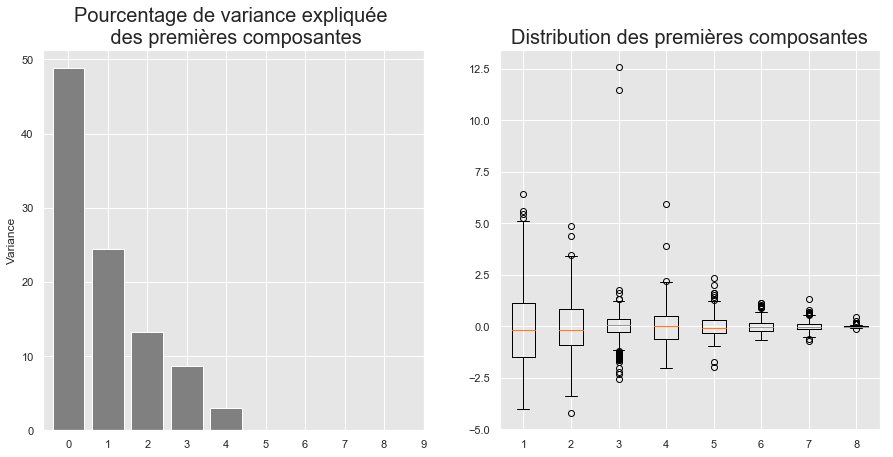

In [13]:
plot_var_ACP(C,pca)

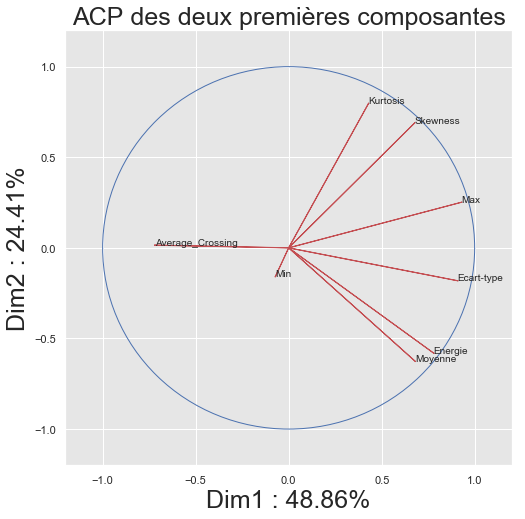

In [14]:
# coordonnées des variables
coord1=pca.components_[0]*np.sqrt(pca.explained_variance_[0])
coord2=pca.components_[1]*np.sqrt(pca.explained_variance_[1])
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
for i, j, nom in zip(coord1,coord2, data.columns):
    plt.text(i, j, nom)
    plt.arrow(0,0,i,j,color='r')
plt.axis((-1.2,1.2,-1.2,1.2))
# cercle
c=plt.Circle((0,0), radius=1, color='b', fill=False)
ax.add_patch(c)
ax.set_xlabel("Dim1 : " + str(round(pca.explained_variance_ratio_[:10][0]*100,2))+ "%" ,size=25)
ax.set_ylabel("Dim2 : " + str(round(pca.explained_variance_ratio_[:10][1]*100,2)) + "%",size=25)
ax.set_title("ACP des deux premières composantes",size=25)
plt.show()

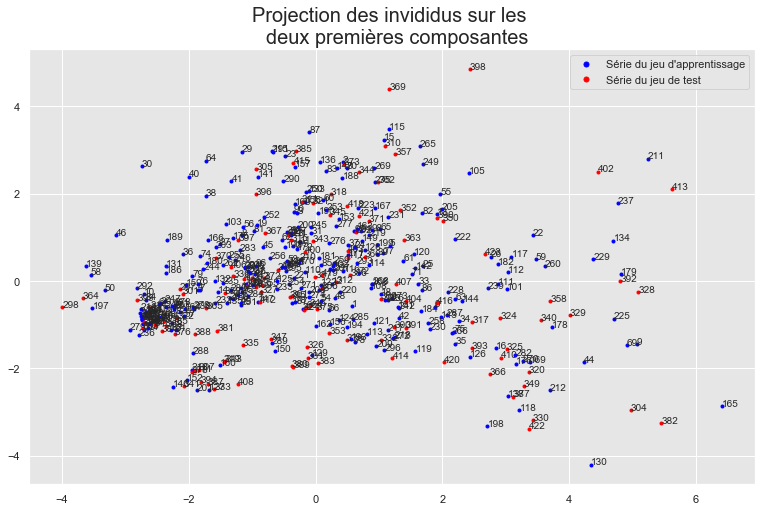

In [15]:
plot_proj_ACP(C)

## OC-SVM 

### Calibration du paramètre nu par recherche dichotomique

In [16]:
outlier_prop = 30 / 297  # Pourcentage estimé d'outliers dans le jeu d'apprentissage
a = 1.e-13
b = 1
gamma = (a + b) / 2
niter = 0
OCSVM = ssvm.OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=gamma)
y_pred = OCSVM.fit(data_train).predict(data_test)
nb_out = np.asarray(y_pred)[np.asarray(y_pred) == 1].shape[0]
while nb_out != 20 and niter < 1e3:
    if nb_out < 20 :
        b = gamma
    else :
        a = gamma
    gamma = (a + b) / 2
    OCSVM = ssvm.OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=gamma)
    y_pred = OCSVM.fit(data_train).predict(data_test)
    nb_out = np.asarray(y_pred)[np.asarray(y_pred) == 1].shape[0]
    niter += 1
print(gamma)

8.9407067163077e-08


In [17]:
OCSVM = ssvm.OneClassSVM(kernel='rbf', nu=outlier_prop, gamma=gamma)
y_pred = OCSVM.fit(data_train).predict(data_test)

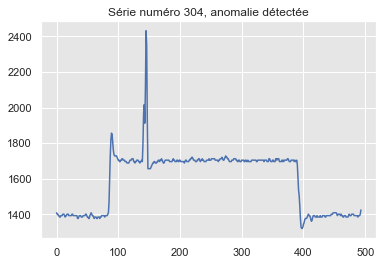

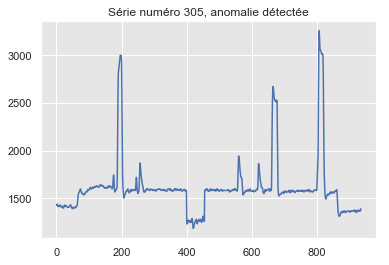

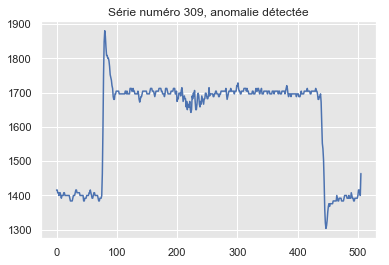

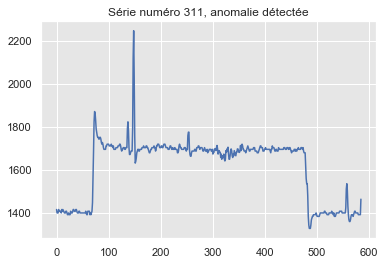

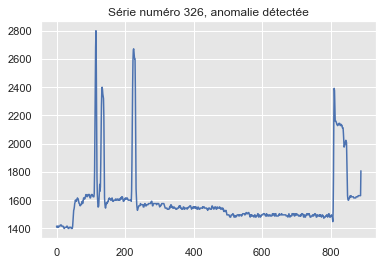

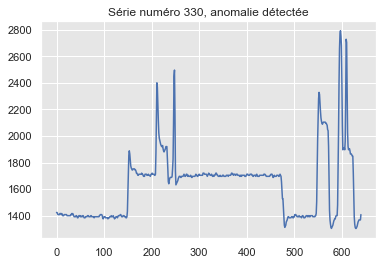

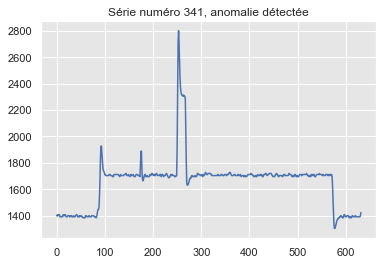

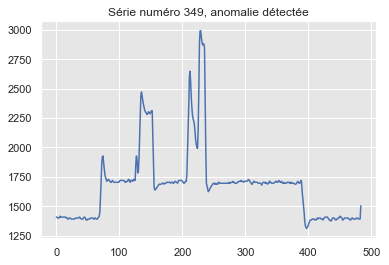

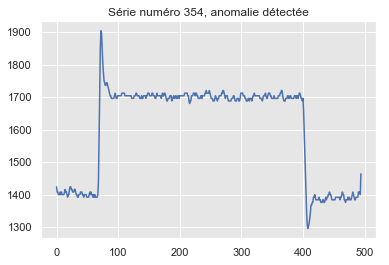

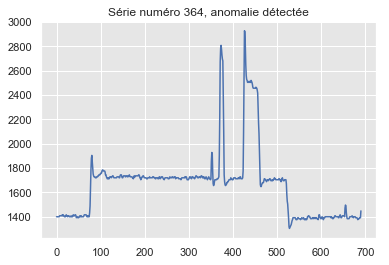

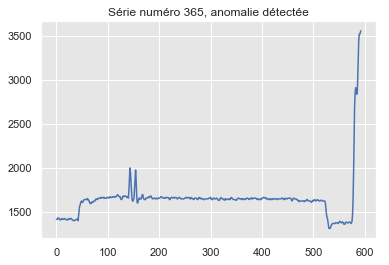

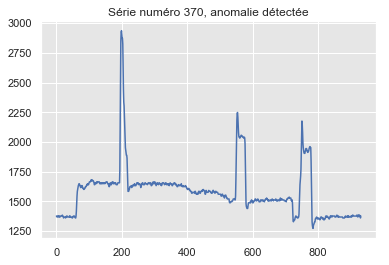

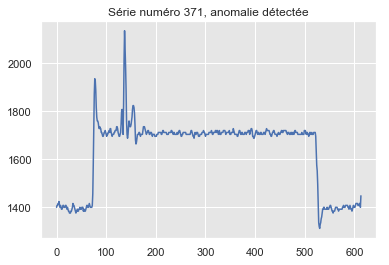

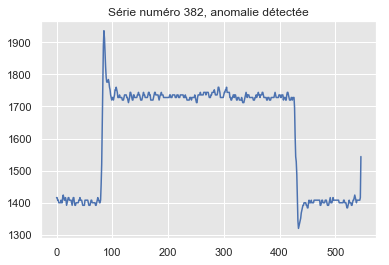

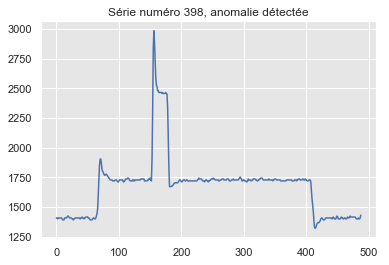

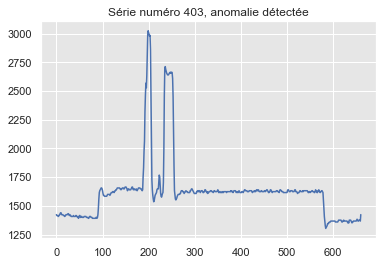

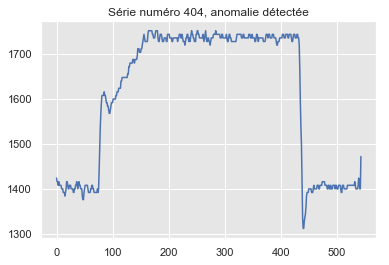

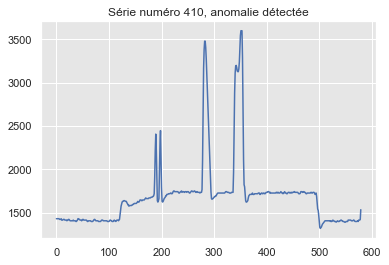

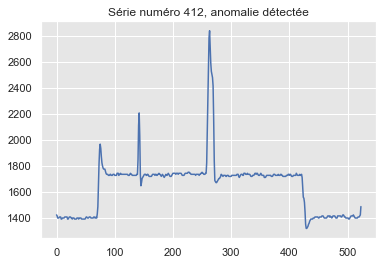

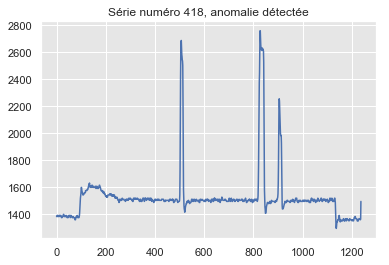

[304, 305, 309, 311, 326, 330, 341, 349, 354, 364, 365, 370, 371, 382, 398, 403, 404, 410, 412, 418]


In [18]:
anom = []
for i, serie in enumerate(liste_test):
    if y_pred[i] == 1:
        anom.append(300 + i)
        plt.plot(serie)
        plt.title("Série numéro " + str(300+i) + ", anomalie détectée")
        plt.show()
    elif False:
        plt.plot(serie)
        plt.title("Série numéro " + str(300+i))
        plt.show()
print(anom)

In [19]:
Coeff_features = DataFeatures.values.tolist()
#Coeff_appr = DataFeatures.iloc[: n_appr].values.tolist()
#Coeff_test = DataFeatures.iloc[n_appr :].values.tolist()

## Liste des différents coefficients sur lesquels appliquer les différentes méthodes

In [20]:
#Liste et dictionnaire des coefficients #Utile pour les fonctions interactives
Coeff_liste=["Tous les coefficients d'ondelettes",
             "Coefficients d'ondelettes, niveau 7",
             "Coefficients d'ondelettes, niveaux 1 à 6",
             "Coefficients d'ondelettes, niveau 1 à 4",
             "Coefficients d'ondelettes seuillés",
             "Coefficients de Fourier",
             "Coefficients de Fourier seuillés",
             "X_1024",
             "Coeffs features"]

dict_coeff ={"Tous les coefficients d'ondelettes" : Coeff_ond,
             "Coefficients d'ondelettes, niveau 7" : Coeff_ond7,
             "Coefficients d'ondelettes, niveaux 1 à 6" : Coeff_ondA6,
             "Coefficients d'ondelettes, niveau 1 à 4" : Coeff_ondA4, 
             "Coefficients d'ondelettes seuillés" : Coeff_ondT,
             "Coefficients de Fourier" : fftCoeff,
             "Coefficients de Fourier seuillés" : fftCoeff_seuil,
             "X_1024" : X_1024,
             "Coeffs features" : Coeff_features}

## Analyse en composantes principales

#### Fonctions d'affichage

In [21]:
def plot_var_ACP(X_acp, acp) :
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,2,1)
    ax.bar(range(10), acp.explained_variance_ratio_[:10]*100, align='center', color='grey', ecolor='black')
    ax.set_xticks(range(10))
    ax.set_ylabel("Variance")
    ax.set_title("Pourcentage de variance expliquée \n des premières composantes", fontsize=20)

    ax = fig.add_subplot(1,2,2)
    box = ax.boxplot(X_acp[:, 0:10])
    ax.set_title("Distribution des premières composantes", fontsize=20)
    plt.show()
    
def plot_proj_ACP(X_acp, axe_1=0, axe_2=1, etiq=True) :
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    dict_color = {True : "blue", False : "red"}

    for x, y, s in zip(X_acp[:,axe_1], X_acp[:,axe_2], ind) :
        ax.plot(x,y,marker=".", color=dict_color[s < 300]) #300 : longueur liste apprentissage
        if etiq :
            ax.text(x, y, str(s))
       
    ax.set_title("Projection des invididus sur les \n  deux premières composantes", fontsize=20)

    legend_elements = [Line2D([0], [0], marker='.', color='blue', label='Série du jeu d\'apprentissage', markersize=10, linewidth=0),
                       Line2D([0], [0], marker='.', color='red', label='Série du jeu de test', markersize=10, linewidth=0)]

    ax.legend(handles=legend_elements)

    plt.show()
    

#### Visualisation des résultats

In [22]:
@interact(Choix_coeff=Coeff_liste)
def ACP(Choix_coeff):
    Coeff=dict_coeff[Choix_coeff]
    acp = sd.PCA()
    X_acp = acp.fit_transform(sp.scale(Coeff))
    plot_var_ACP(X_acp, acp)
    plot_proj_ACP(X_acp, axe_1=0, axe_2=1)

interactive(children=(Dropdown(description='Choix_coeff', options=("Tous les coefficients d'ondelettes", "Coef…

## Classification ascendante hierarchique

#### Fonction d'affichage

In [23]:
def plot_dendrogram(Z,p):
    fig = plt.figure(figsize=(25, 10))
    sch.dendrogram(Z, p, leaf_rotation=45.,leaf_font_size=15, truncate_mode="level", labels=ind)  # font size for the x axis labels
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance')
    plt.show()

#### Visualisation des résultats

In [24]:
@interact(Choix_coeff=Coeff_liste,p=widgets.IntSlider(min=1,max=50,step=1,value=20,continuous_update=False))
def CAH(Choix_coeff,p):
    Coeff=dict_coeff[Choix_coeff]
    Z = sch.linkage(Coeff, 'single')
    C = np.array([c[0] for c in sch.cut_tree(Z,5)])
    CT = pd.DataFrame(list(C), columns=["HCA_cluster"])
    plot_dendrogram(Z,p)
    

interactive(children=(Dropdown(description='Choix_coeff', options=("Tous les coefficients d'ondelettes", "Coef…

### Fonction d'affichage des anomalies

In [25]:
def print_anomalies(ind_anomalies,ind_data = ind):
    """Permet d'afficher le bon indice de la série dans le cas où des series ont été supprimées du jeu de données"""
    return [ind_data[i] for i in ind_anomalies]

## Isolation Forest

#### Visualisation des résultats

In [26]:
contamination=20/len(liste_test)
n_estimators=100

@interact(Choix_coeff=Coeff_liste)
def plot_IF_anomaly(Choix_coeff):
    Coeff=dict_coeff[Choix_coeff]
    Coeff_appr = Coeff[: n_appr]
    Coeff_test = Coeff[n_appr :]
    clf = se.IsolationForest(n_estimators=n_estimators, contamination=contamination, bootstrap=True, behaviour="new", n_jobs=-1)
    pred = clf.fit(Coeff_appr).predict(Coeff_test)
    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    
    pred_complet = [1] * n_appr + list(pred)
    
    for i, j, nom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred_complet, ind):
        color = "red" if nom!=1  else "grey"
        plt.plot(i, j, "o", color=color) 
        if nom!=1:
            ax.text(i,j,str(s))
    ax.set_title("Repésentation des atypiques sur la projection des 2 premières composantes de l'ACP", fontsize=20)
    plt.show()
    
    print("Anomalies détectées : ", print_anomalies([i for i, x in enumerate(pred_complet) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=("Tous les coefficients d'ondelettes", "Coef…

## One Class SVM

#### Visualisation des résultats

In [27]:
kernel="rbf"
#nu=30/len(liste_appr) # Pourcentage estimé d'outliers dans le jeu d'apprentissage
gamma=1e-11

@interact(Choix_coeff=Coeff_liste,nu=widgets.FloatSlider(min=0.01,max=1.0,step=0.01,value=0.05))
def plot_OCSVM_anomaly(Choix_coeff,nu):
    Coeff=dict_coeff[Choix_coeff]
    Coeff_appr = Coeff[: n_appr]
    Coeff_test = Coeff[n_appr :]
    
    OCS = ssvm.OneClassSVM(kernel=kernel, nu=nu, gamma=gamma)
    pred = OCS.fit(Coeff_appr).predict(Coeff_test)
    pred_complet = [1] * n_appr + list(pred)

    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    for i, j, nom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred_complet, ind):
        color = "red" if nom!=1  else "grey"
        plt.plot(i, j, "o",color=color) 
        if nom!=1:
            ax.text(i,j,str(s))
    ax.set_title("Repésentation des atypiques sur la projection des 2 premières composantes de l'ACP", fontsize=20)
    plt.show()
    
    print("Anomalies détectées : ", print_anomalies([i for i, x in enumerate(pred_complet) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=("Tous les coefficients d'ondelettes", "Coef…

## Local Outlier Factor

#### Visualisation des résultats

In [28]:
contamination=20/len(liste_test)
metric = "euclidean"
#n_neighbors = 15

@interact(Choix_coeff=Coeff_liste,n_neighbors=widgets.IntSlider(min=1,max=30,step=1,value=15))
def plot_LOF_anomaly(Choix_coeff,n_neighbors):
    Coeff=dict_coeff[Choix_coeff]
    Coeff_appr = Coeff[: n_appr]
    Coeff_test = Coeff[n_appr :]
    
    clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric, novelty=True)
    pred = clf.fit(Coeff_appr).predict(Coeff_test)
    pred_complet = [1] * n_appr + list(pred)

    acp_ond = sd.PCA()
    X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))
    
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(1,1,1)
    for i, j, nom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred_complet, ind):
        color = "red" if nom!=1  else "grey"
        plt.plot(i, j, "o",color=color) 
        if nom!=1:
            ax.text(i,j,str(s))
    ax.set_title("Repésentation des atypiques sur la projection des 2 premières composantes de l'ACP", fontsize=20)
    plt.show()
    
    print("Anomalies détectées : ", print_anomalies([i for i,x in enumerate(pred_complet) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=("Tous les coefficients d'ondelettes", "Coef…

## Comparaison des méthodes IF, OC-SVM et LOF

In [30]:
methode_liste = ["Classification ascendante hierarchique","Isolation Forest", "One-Class SVM", "Local Outlier Factor"]
p=20 #CAH
contamination = 20 / len(liste_test) #IF, LOF
n_neighbors = 15 #LOF
nu = 0.05 #OC-SVM
gamma= 1e-11#OC-SVM

#A CONSERVER : peut etre utile pour faire le choix des parametres
def f(**args):
    return args

@interact(Choix_coeff=Coeff_liste, methode=methode_liste)
def plot_anomaly(Choix_coeff, methode):
    Coeff=dict_coeff[Choix_coeff]
    Coeff_appr = Coeff[: n_appr]
    Coeff_test = Coeff[n_appr :]
    
    if methode=="Classification ascendante hierarchique":
        Coeff=dict_coeff[Choix_coeff]
        Z = sch.linkage(Coeff, 'single')
        C = np.array([c[0] for c in sch.cut_tree(Z,5)])
        plot_dendrogram(Z,p)
    else :
        
        if methode=="Local Outlier Factor":
            clf = sn.LocalOutlierFactor(n_neighbors=n_neighbors, contamination=contamination, metric=metric, novelty=True)
            pred = clf.fit(Coeff_appr).predict(Coeff_test)
        elif methode=="Isolation Forest":
            clf = se.IsolationForest(n_estimators=n_estimators, contamination=contamination, bootstrap=True, behaviour="new", n_jobs=-1)
            pred = clf.fit(Coeff_appr).predict(Coeff_test)
        elif methode=="One-Class SVM":
            OCS = ssvm.OneClassSVM(kernel=kernel, nu=nu, gamma=gamma)
            pred = OCS.fit(Coeff_appr).predict(Coeff_test)
        
        pred_complet = [1] * n_appr + list(pred)
        if False:
            acp_ond = sd.PCA()
            X_acp_ond = acp_ond.fit_transform(sp.scale(Coeff))

            fig = plt.figure(figsize=(15,10))
            ax = fig.add_subplot(1,1,1)
            for i, j, nom, s in zip(X_acp_ond[:,0], X_acp_ond[:,1], pred_complet, ind):
                color = "red" if nom!=1  else "grey"
                plt.plot(i, j, "o",color=color) 
                if nom!=1:
                    ax.text(i,j,str(s))
            plt.show()
    
        print("Anomalies détectées : ", print_anomalies([i for i, x in enumerate(pred_complet) if x!=1]))

interactive(children=(Dropdown(description='Choix_coeff', options=("Tous les coefficients d'ondelettes", "Coef…

Anomalies par méthode :

-  LOF :
* Tous coeffs :         [307, 323, 327, 328, 331, 332, 343, 352, 353, 361, 369, 380, 385, 389, 393, 395, 396, 410, 413, 416, 423, 425, 426]
* Ondelettes 7 :        [313, 315, 323, 331, 343, 352, 353, 361, 369, 385, 393, 395, 396, 410, 416, 419, 425, 426]
* Ondelettes 1-6 :      [307, 323, 327, 328, 331, 332, 333, 343, 352, 353, 355, 361, 369, 380, 385, 389, 393, 395, 396, 410, 413, 416, 423, 425, 426]
* Ondelettes 1-4 :      [307, 323, 327, 328, 331, 332, 333, 335, 343, 346, 352, 361, 364, 369, 380, 385, 389, 393, 395, 396, 399, 413, 416, 417, 423, 425]
* Ondelettes seuillés : [307, 323, 327, 328, 331, 332, 343, 352, 353, 361, 369, 380, 385, 389, 393, 395, 396, 410, 413, 416, 423, 425, 426]
* Fourier :             [315, 323, 327, 335, 343, 346, 349, 353, 364, 369, 389, 396, 406, 410, 417, 419, 421, 423]
* Fourier seuillés :    [315, 323, 327, 335, 343, 346, 349, 353, 364, 369, 389, 396, 406, 410, 417, 419, 423]
* X_1024 :              [307, 323, 327, 328, 331, 332, 343, 352, 353, 361, 369, 380, 385, 389, 393, 395, 396, 410, 413, 416, 423, 425, 426]
* Features :            [301, 303, 307, 308, 312, 314, 320, 327, 328, 333, 367, 376, 385, 386, 394, 396, 399, 418, 423, 425]


- OC-SVM :
* Tous coeffs :         [307, 323, 327, 328, 332, 333, 343, 352, 380, 385, 395, 396, 425]
* Ondelettes 7 :        [323, 331, 343, 352, 369, 385, 395, 416, 426]
* Ondelettes 1-6 :      [307, 327, 328, 332, 333, 343, 380, 385, 395, 396]
* Ondelettes 1-4 :      [307, 323, 327, 328, 332, 333, 385, 395, 423]
* Ondelettes seuillés : [307, 323, 327, 328, 332, 333, 343, 352, 380, 385, 395, 396, 425]
* Fourier :             [301, 307, 323, 327, 328, 332, 333, 343, 369, 385, 395, 396, 402, 410, 419, 423, 425]
* Fourier seuillés :    [301, 307, 323, 327, 328, 332, 333, 343, 369, 385, 395, 396, 402, 410, 419, 423, 425]
* X_1024 :              [307, 323, 327, 328, 332, 333, 343, 352, 380, 385, 395, 396, 425]
* Features :            [307, 328, 329, 332, 333, 334, 343, 349, 359, 383, 385, 389, 398, 405, 411, 413, 417, 425]



- IF :
* Tous coeffs :         [303, 323, 328, 343, 352, 353, 361, 369, 380, 385, 396, 413, 419, 423, 425]
* Ondelettes 7 :        [323, 331, 343, 346, 352, 353, 361, 369, 380, 385, 395, 396, 419, 422, 425]
* Ondelettes 1-6 :      [305, 307, 323, 328, 332, 333, 335, 343, 346, 352, 353, 361, 363, 369, 380, 385, 395, 396, 410, 417, 423, 425, 426]
* Ondelettes 1-4 :      [307, 323, 327, 328, 331, 332, 333, 335, 343, 352, 361, 369, 380, 385, 389, 395, 396, 413, 416, 417, 423, 425]
* Ondelettes seuillés : [323, 331, 343, 352, 353, 361, 369, 380, 385, 395, 410, 419, 425]
* Fourier :             [307, 323, 327, 343, 352, 361, 369, 385, 389, 394, 395, 396, 413, 419, 420, 421, 425]
* Fourier seuillés :    [307, 323, 327, 328, 331, 332, 333, 343, 352, 353, 361, 369, 372, 385, 393, 395, 396, 406, 410, 413, 419, 421, 425, 426]
* X_1024 :              [307, 323, 327, 328, 331, 332, 333, 335, 343, 345, 346, 352, 353, 359, 361, 369, 376, 380, 385, 386, 389, 395, 396, 405, 407, 410, 413, 416, 417, 420, 422, 423, 424, 425]
* Features :            [301, 307, 310, 313, 320, 323, 327, 328, 331, 332, 333, 334, 336, 340, 343, 344, 350, 352, 360, 361, 367, 369, 372, 374, 376, 378, 380, 381, 385, 386, 390, 392, 393, 394, 395, 397, 401, 405, 411, 414, 416, 418, 425]

- Cf application article :
* Avec ACP :            [316, 318, 322, 325, 335, 336, 344, 345, 346, 357, 359, 370, 372, 390, 401, 402, 407, 410, 422, 426]
* Sans ACP :            [316, 318, 322, 325, 335, 336, 344, 345, 346, 357, 359, 370, 401, 402, 407, 422]